In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from filterpy.monte_carlo import systematic_resample
import seaborn as sns


In [35]:
# Đọc dữ liệu
df = pd.read_csv(r"D:\Đại học thủy lợi\Phân tích chuỗi thời gian\TH_02\BTC.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,404.424988,21460800


In [36]:
# Chuyển đổi ngày và sắp xếp
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [37]:
duplicates = df.index.duplicated().sum()

In [38]:
# Chỉ lấy giá đóng cửa
df['log_return'] = np.log(df['Close']).diff().fillna(0)
returns = df['log_return'].values.reshape(-1, 1)

In [39]:
# Số regime (có thể thử 2, 3 hoặc 4)
n_components = 3

# Khởi tạo và huấn luyện mô hình
model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
model.fit(returns)

# Lấy ra trạng thái ẩn đã dự đoán
hidden_states = model.predict(returns)
df['Regime'] = hidden_states


Model is not converging.  Current: 3929.042491575078 is not greater than 3929.0636411566825. Delta is -0.021149581604277046


In [40]:
# Hàm Particle Filtering đơn giản
def particle_filter(obs, model, N=100):
    T = len(obs)
    particles = np.random.choice(model.n_components, size=N)
    weights = np.ones(N) / N
    filtered_states = []

    for t in range(T):
        # Predict next state
        trans_probs = model.transmat_[particles]
        new_particles = [np.random.choice(model.n_components, p=trans_probs[i]) for i in range(N)]

        
        obs_prob = np.array([
            model._compute_log_likelihood(obs[t].reshape(1, -1))[0, s]

            for s in new_particles
        ])
        weights *= np.exp(obs_prob).flatten()
        weights += 1e-300  # tránh chia cho 0
        weights /= np.sum(weights)

        # Resample
        indexes = systematic_resample(weights)
        particles = np.array(new_particles)[indexes]
        weights = np.ones(N) / N

        # Lưu lại trạng thái phổ biến nhất (mode)
        counts = np.bincount(particles, minlength=model.n_components)
        filtered_states.append(np.argmax(counts))

    return filtered_states


In [41]:
filtered_states = particle_filter(returns, model, N=100)
df['PF_Regime'] = filtered_states


In [42]:
y_test = df['Regime']
y_pred = df['PF_Regime']

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [44]:

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.1992
Root Mean Squared Error (RMSE): 0.4895


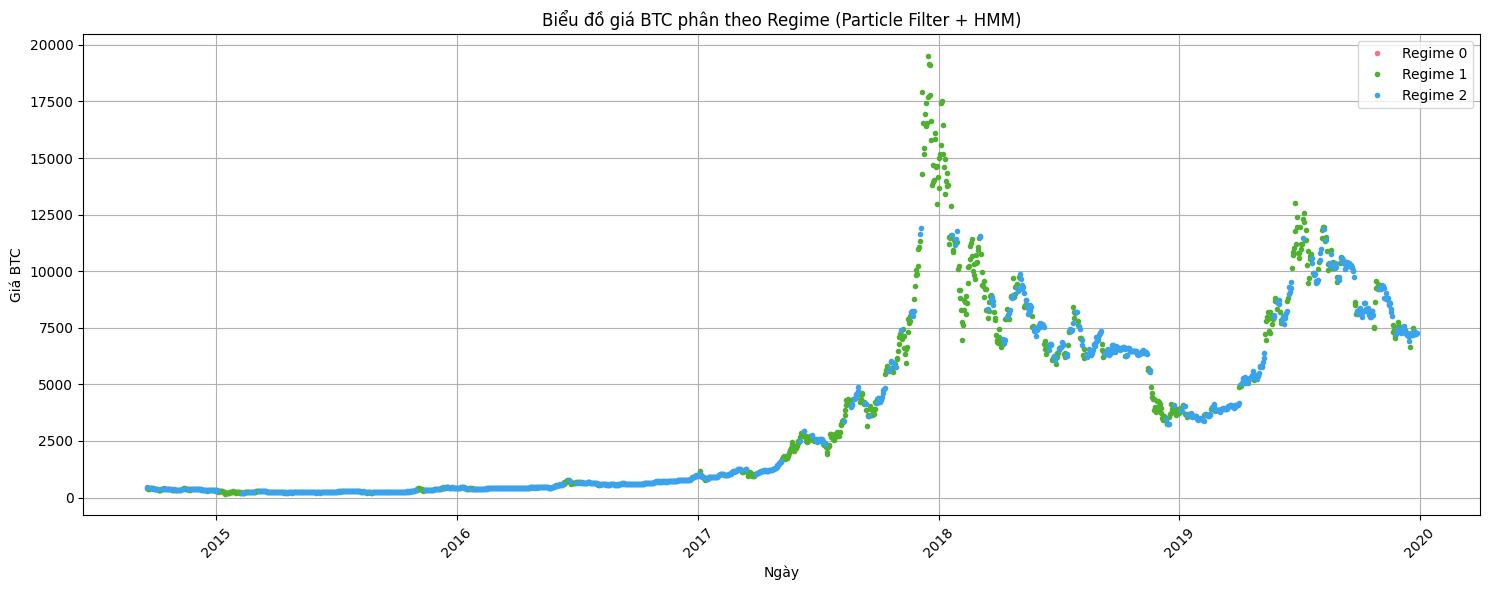

In [45]:


# Chọn bảng màu phù hợp với số chế độ (n_components)
palette = sns.color_palette("husl", n_components)

# Tạo biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ các chế độ cho từng điểm dữ liệu trong các chế độ khác nhau
for i in range(n_components):
    plt.plot(df['Date'][df['PF_Regime'] == i],
             df['Close'][df['PF_Regime'] == i],
             '.', label=f'Regime {i}', color=palette[i])

# Hiển thị legend, tiêu đề và các nhãn trục
plt.legend()
plt.title("Biểu đồ giá BTC phân theo Regime (Particle Filter + HMM)")
plt.xlabel("Ngày")
plt.ylabel("Giá BTC")

# Hiển thị biểu đồ
plt.xticks(rotation=45)  # Xoay nhãn ngày cho dễ đọc
plt.grid(True)
plt.tight_layout()  # Cải thiện hiển thị, tránh bị tràn nhãn

# Hiển thị biểu đồ
plt.show()
